In [1]:
'''
Trying to improve the dcan_signal_processing.m by doing it in python and getting rid of all the CIFTI I/O done through wb_command
'''

'\nTrying to improve the dcan_signal_processing.m by doing it in python and getting rid of all the CIFTI I/O done through wb_command\n'

In [3]:
import json
import math
import os
import nibabel as nib
import pandas as pd
import numpy as np
import scipy
from subprocess import check_call
from glob import glob
import matplotlib.pyplot as plt  # If checking the output
from scipy.io import loadmat

In [4]:
#json_path = r"/data/wheelock/data1/datasets/BCP/Example_BCP_intermediates/sub-100619/output_Tu/MNINonLinear/Results/ses-17mo_task-rest_run-001/DCANBOLDProc_vTu1.0/DCANBOLDProc_vTu1.0_mat_config_20240913.json"
json_path = r"/data/wheelock/data1/datasets/BCP/Example_BCP_intermediates/sub-100619/output_Tu/MNINonLinear/Results/ses-17mo_task-rest_run-001/DCANBOLDProc_v4.0.0/DCANBOLDProc_v4.0.0_mat_config_20240913.json"
# Load the json file
with open(json_path, 'r') as file:
    json_input = json.load(file)
globals().update(json_input) # unwraps the dictionary into global variables (Line 9 in dcan_signal_processing.m)
json_input

{'FNL_preproc_CIFTI_basename': 'ses-17mo_task-rest_run-001_DCANBOLDProc_v4.0.0_Atlas_Python',
 'TR': 0.8,
 'bp_order': 2,
 'fMRIName': 'ses-17mo_task-rest_run-001',
 'fd_th': 0.3,
 'file_mov_reg': '/data/wheelock/data1/datasets/BCP/Example_BCP_intermediates/sub-100619/output_Tu/MNINonLinear/Results/ses-17mo_task-rest_run-001/DCANBOLDProc_v4.0.0/DCANBOLDProc_v4.0.0_bs16.8896_28.6662_filtered_Movement_Regressors.txt',
 'file_vent': '/data/wheelock/data1/datasets/BCP/Example_BCP_intermediates/sub-100619/output_Tu/MNINonLinear/Results/ses-17mo_task-rest_run-001/DCANBOLDProc_v4.0.0/ses-17mo_task-rest_run-001_vent_mean.txt',
 'file_wm': '/data/wheelock/data1/datasets/BCP/Example_BCP_intermediates/sub-100619/output_Tu/MNINonLinear/Results/ses-17mo_task-rest_run-001/DCANBOLDProc_v4.0.0/ses-17mo_task-rest_run-001_wm_mean.txt',
 'hp_Hz': 0.08,
 'lp_Hz': 0.009,
 'motion_filename': 'motion_numbers.txt',
 'path_cii': '/data/wheelock/data1/datasets/BCP/Example_BCP_intermediates/sub-100619/output_Tu/

In [5]:
# Dependency functions

def calculate_dvars_from_cifti(data):
    """
    This function calculates DVARS (Derivative of Variance) based on grayordinates (WM and non-brain excluded).
    
    Parameters:
    data (ndarray): 2D numpy array with shape (tr, g), where g represents the number of grayordinates and tr is the number of time points.
    
    Returns:
    dvars (float): The calculated DVARS value.
    """
    # Check size and transpose if needed
    num_timepoints,num_grayordinates  = data.shape
    if num_grayordinates < num_timepoints:
            data = data.T
            print('data transposed due to timepoints > grayordinates, double check input')

    # Calculate differences across timepoints
    data_diff = np.diff(data, axis=0)

    # Calculate DVARS as the root mean square of the differences
    dvars = np.hstack((np.nan,np.sqrt(np.mean(data_diff ** 2,axis=1))))

    return dvars

def filter_movement_regressors(signal, TR, order, filt_type, fc_RR_min, fc_RR_max):   
    fs = 1 / TR
    fNy = fs / 2 # Nyquist frequency
    if filt_type == 'lp':
        freq_low = fc_RR_min / 60 # Hz lower range
        b_filt,a_filt = scipy.signal.butter(order/2,freq_low/fNy,'lowpass',axis = 0) # Division by 2 because filtfilt applies the filter forward and backward, making the filter order twice the original one
    elif (filt_type == 'notch') | (filt_type == 'bandstop'):
        freq_low = fc_RR_min / 60  # Hz, lower range
        freq_high = fc_RR_max / 60  # Hz, higher range
        b_filt,a_filt = scipy.signal.butter(order/2,np.array([freq_low,freq_high])/fNy,'bandstop') # Division by 2 because filtfilt applies the filter forward and backward, making the filter order twice the original one
    
    filtered_signal = scipy.signal.filtfilt(b_filt,a_filt,signal,axis = 0)   

    return filtered_signal

def calc_FD(R, FD_type=1):

    dR = np.diff(R,axis = 0) # First-order derivative
    ddR = np.diff(dR,axis = 0)  # Second-order derivative
    if FD_type == 1:
        # L1-norm - sum of absolute values of first-order derivatives
        FD = np.sum(np.absolute(dR), axis=1) 
        meanFD = np.mean(FD)
        FD = np.hstack((np.zeros(1,),FD)) # Pad zeros to make it the same length as the original data
    elif FD_type == 2:
        # L2-norm - sum of absolute values of second-order derivatives
        FD = np.sum(np.absolute(ddR),axis=1)
        meanFD = np.mean(FD)
        FD = np.hstack((np.zeros(2,),FD))# Pad zeros to make it the same length as the original data
    return FD,meanFD 

def make_friston_regressors(MR):
    """
    This function takes a matrix `MR` of 6 degrees of freedom (DOF) movement correction
    parameters and calculates the corresponding 24 Friston regressors.

    Parameters:
    -----------
    MR : numpy array of shape (r, c)
        A matrix where r is the number of time points and c are the 6 DOF movement regressors.
        If the number of columns is more than 6, only the first 6 columns are considered.

    hd_mm : float, optional
        The head radius in mm. Default is 50 mm.

    Returns:
    --------
    FR : numpy array of shape (r, 24)
        A matrix containing 24 Friston regressors.
    """

    # Calculate the first part of the Friston regressors (MR and MR^2)
    FR = np.hstack([MR, MR**2])

    # Create a dummy array for the temporal derivatives (lagged version of FR)
    dummy = np.zeros_like(FR)
    dummy[1:, :] = FR[:-1, :]  # shift FR by one time step
    dummy[0, :] = 0  # set the first row to 0

    # Concatenate the original FR and the lagged version
    FR = np.hstack([FR, dummy])

    return FR

def calc_power_spectrum(data):
    assert len(data.shape) == 1 or data.shape[1] == 1,"Input has to be a column vector or 1D array"
    N = data.shape[0]
    yf = scipy.fftpack.fft(data)
    power_spectrum = 2.0 / N * np.abs(yf[0 : N // 2])
    return power_spectrum

def detrend_manual(data, keepframe):
    detrended_data = data.copy()
    time_points = np.where(keepframe)[0]
    time_points_all = np.array(range(keepframe.shape[0]))
    
    # Create the design matrix for linear regression (constant + linear term)
    X = np.vstack([time_points, np.ones(len(time_points))]).T  # Shape (len(keepframe), 2)
    Xall = np.vstack([time_points_all, np.ones(len(time_points_all))]).T 

    # Perform the linear regression for all columns at once using least squares
    # Y is the data[keepframe, :] with shape (len(keepframe), n)
    Y = data[keepframe, :]
    
    # Compute the least squares solution to find the slope and intercept for each column
    beta, _, _, _ = np.linalg.lstsq(X, Y, rcond=None)  # beta shape is (2, n)
    
    # Calculate the trend for each column using the coefficients
    trend = Xall @ beta  # Shape (len(keepframe), n)

    # Subtract the trend from the data at the all indices
    detrended_data -= trend

    # Using the for loop is much slower
    # x = np.array(range(np.shape(keepframe)[0]))
    # # Loop through each column in the data
    # for i in range(data.shape[1]):
    #     # Extract the values in the rows defined by keepframe for the current column
    #     y = data[keepframe, i]
        
    #     # Fit a linear trend (y = mx + b)
    #     p = np.polyfit(time_points, y, 1)  # First-order polynomial fit (linear)

    #     # Calculate the trend (mx + b)
    #     trend = np.polyval(p, x)

    #     # Subtract the trend from the original data at the keepframe indices
    #     detrended_data[:, i] -= trend
    return detrended_data
    

### Preparation and load data

In [6]:
# Get TR (Line 34 in dcan_signal_processing.m)
TR = nib.load(path_cii).header.get_axis(0).step  # In seconds
if TR>20: # handle niftis that store TR in ms 
    TR /= 1000
print('TR = ' + str(TR))
skip_frames = math.floor(skip_seconds/TR)

TR = 0.8


In [7]:
# Read cifti data (Line 43 in dcan_signal_processing)
img = nib.load(path_cii)
data = img.get_fdata()
DVAR_pre_reg = calculate_dvars_from_cifti(data)
# # Visualization
# plt.plot(DVAR_pre_reg)
# plt.show()

In [ ]:
# Global signals (Line 52,58,83 in dcan_bold_processing.m)
if GSR:
    wm = np.loadtxt(file_wm)
    vent = np.loadtxt(file_vent)
    WB = np.mean(data,axis = 1) # Global signal in gray matter
    Glob = np.concatenate((wm.reshape(-1,1),vent.reshape(-1,1),WB.reshape(-1,1)),axis = 1)
    dGlob  = np.vstack(([0,0,0],np.diff(Glob,axis=0)))
    # Visualization
    plt.figure(figsize = (8,4))
    plt.subplot(1,2,1)
    plt.plot(Glob,lw = 0.5,label =('white matter','ventricle','grayordinate'))
    plt.title('Global signal')
    plt.subplot(1,2,2)
    plt.plot(dGlob,lw = 0.5,label =('white matter','ventricle','grayordinate'))
    plt.legend()
    plt.title('Global signal derivative')
    plt.show()

In [12]:
# Load movement regressors
assert os.path.isfile(file_mov_reg), 'movement regressor file not found' 
unfiltered_mov_regressors = np.loadtxt(file_mov_reg)
unfiltered_mov_regressors = unfiltered_mov_regressors[:,:6]
# Convert rotational motion parameters (4th to 6th columns) from degrees to arc length in mm
unfiltered_mov_regressors[:, 3:] *= np.pi * brain_radius_mm / 180

# Bandstop filter
filtered_mov_regressors = filter_movement_regressors(unfiltered_mov_regressors, TR, motion_filter_order, motion_filter_type, band_stop_min, band_stop_max)

FR = make_friston_regressors(filtered_mov_regressors) # 24-param Friston Regressors

In [ ]:
# Calculate FD  (Line 73 in dcan_bold_processing.m)
FD,meanFD = calc_FD(filtered_mov_regressors,FD_type=FD_type)
FD_file_name = os.path.join(result_dir,FNL_preproc_CIFTI_basename + '_FD.txt')
np.savetxt(FD_file_name,FD)
print('Mean FD = ' + str(meanFD))
# Now state the frames to keep for the processing (Line 78 in dcan_bold_processing.m)
keepframe = FD <= fd_th
skip_frames = np.int8(np.floor(skip_seconds/TR))
keepframe[:skip_frames]=False
np.sum(keepframe)

In [ ]:
# # Load FD and FR
# FD = loadmat('/data/wheelock/data1/datasets/BCP/Example_BCP_intermediates/sub-100619/output_Tu/MNINonLinear/Results/ses-17mo_task-rest_run-001/DCANBOLDProc_v4.0.0/FD.mat')['FD']
# FD = np.vstack((0,FD)).ravel()
# keepframe = FD <= fd_th
# skip_frames = np.int8(np.floor(skip_seconds/TR))
# keepframe[:skip_frames]=False

# FR = loadmat('/data/wheelock/data1/datasets/BCP/Example_BCP_intermediates/sub-100619/output_Tu/MNINonLinear/Results/ses-17mo_task-rest_run-001/DCANBOLDProc_v4.0.0/FR.mat')['FR']
# FR.shape

In [ ]:
# Visualization
plt.figure()
plt.plot(FD,lw=0.5)
for j in np.where(keepframe==0)[0]:
    plt.axvline(x=j, color=[0.2,0.2,0.2], alpha=0.2)
plt.title('FD')
plt.show()

In [ ]:
# Concatenate regressors
if GSR:
    R = np.concatenate((Glob,dGlob,FR),axis = 1) # with GSR
else:
    R = FR # without GSR
# Demean/detrend regressors
R = R-np.mean(R[keepframe,:],axis = 0)
R = detrend_manual(R,keepframe)
plt.figure()
plt.plot(R)
plt.xlabel('TR')
plt.show()

### Start Processing fMRI data

In [ ]:
data_dd = data-np.mean(data[keepframe,:],axis=0)
data_dd = detrend_manual(data_dd,keepframe)

In [ ]:
plt.figure()
plt.subplot(1,2,1)
plt.plot(np.mean(data,axis=1))
plt.xlabel('TR')
plt.title('Before demean/detrend')
plt.subplot(1,2,2)
plt.plot(np.mean(data_dd,axis=1))
plt.xlabel('TR')
plt.title('After demean/detrend')
plt.show()
plt.tight_layout()

In [ ]:
tmpdvar = calculate_dvars_from_cifti(data_dd)
plt.plot(DVAR_pre_reg,label = 'original')
plt.plot(tmpdvar,label = 'demean/detrend')
plt.legend()
plt.title('DVARS')
plt.show()

In [ ]:
# Nuisance Regression (Line 121 in dcan_signal_processing.m)
b,_,_,_ = np.linalg.lstsq(R[keepframe,:],data_dd[keepframe,:],rcond=None)
data_postreg = data_dd-R@b
DVAR_post_reg = calculate_dvars_from_cifti(data_postreg)

In [ ]:
plt.figure()
plt.plot(DVAR_pre_reg,linewidth=0.5,label='DVARS pre regression')
plt.plot(DVAR_post_reg,linewidth=0.5,label='DVARS post regression')
plt.xlabel('TR')
plt.legend()
plt.show()

In [ ]:
# Linear interpolation before bandpass filter (Line 144 in dcan_signal_processing.m)
# Interpolate for missing frames
x = np.where(keepframe)[0]
x_removed =  np.where(keepframe==0)[0]
x_outsidebound = (x_removed<x[0])|(x_removed>x[-1])
y_removed = np.apply_along_axis(
    lambda col: np.interp(x_removed, x, col[keepframe]), 
    axis=0, 
    arr=data_postreg
)
# Replace extrapolated points with the mean of kept data
y_mean = np.mean(data_postreg[keepframe,:],axis=0)
y_removed[x_outsidebound,:] = y_mean 

data_interpolated = data_postreg.copy()
data_interpolated[keepframe==0,:] = y_removed

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(data_postreg[:,0],linewidth=0.5,label='example original signal')
plt.plot(data_interpolated[:,0],linewidth=0.5,label='example interpolated signal')
# for j in x_removed[x_outsidebound]:
#     plt.axvline(x=j, color="r", alpha=0.2)
plt.xlabel('TR')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [ ]:
# Bandpass filter with manual zero padding
fs = 1 / TR
fNy = fs / 2 # Nyquist frequency
b_filt,a_filt = scipy.signal.butter(bp_order/2,np.array([lp_Hz,hp_Hz])/fNy,'bandpass')
# Zero-pad the data for filtering by concatenating rows of zeros on either side of the data
padding = np.zeros_like(data_interpolated)  # Create a padding array of the same shape as Rr_int
pad_amt = padding.shape[0]       # Number of rows to pad

# Concatenate padding rows on top and bottom of Rr_int
temp = np.vstack((padding, data_interpolated, padding))

# Apply the filtfilt function (zero-phase filtering)
data_filtered  = scipy.signal.filtfilt(b_filt, a_filt, temp, axis=0,padtype=None)  # Apply filtering along the rows (axis=0)
data_filtered = data_filtered[pad_amt:-pad_amt]

DVAR_post_filter = calculate_dvars_from_cifti(data_filtered)

In [ ]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(data_interpolated[:,0],linewidth=0.5,label='Pre-filtered signal')
plt.plot(data_filtered[:,0],linewidth=0.5,label='Post-filtered signal')
# for j in x_removed[x_outsidebound]:
#     plt.axvline(x=j, color="r", alpha=0.2)
plt.xlabel('TR')
plt.legend(loc='best')
plt.title('Example signal')

plt.subplot(1,2,2)
n = data_filtered.shape[0]
frequencies = fs*np.arange(0,n//2+1)/n
plt.plot(frequencies[1:],calc_power_spectrum(data_interpolated[:,0]),linewidth=0.5,label='Power spectrum for example signal (pre-filter)')
plt.plot(frequencies[1:],calc_power_spectrum(data_filtered[:,0]),linewidth=0.5,label='Power spectrum for example signal (post-filter)')
plt.xlabel('Hz')
plt.title('Frequency spectrum')
plt.tight_layout()
plt.show()

plt.figure(figsize=(2,2))
plt.plot(DVAR_post_filter,linewidth=0.5,label='DVARS post bandpass filter')
plt.xlabel('TR')
plt.title('DVARS')
plt.ylim([0,40])
plt.show()

plt.figure(figsize=(2,2))
plt.plot(frequencies[1:],calc_power_spectrum(data_filtered[:,0]),linewidth=0.5,label='Power spectrum for example signal (post-filter)')
plt.xlabel('TR')
plt.title('Frequency spectrum')
plt.ylim([-0.5,15.5])
plt.show()

In [ ]:
plt.figure(figsize=(4,4))
plt.plot(DVAR_pre_reg,linewidth=0.5,label='DVARS pre regression',color='b')
plt.plot(DVAR_post_reg,linewidth=0.5,label='DVARS post regression',color='r')
plt.plot(DVAR_post_filter,linewidth=0.5,label='DVARS post filtered',color='g')
plt.xlabel('TR')
plt.legend()
plt.show()

In [ ]:
# Make cifti header to save filtered data
# img = nib.load(path_cii)  # This line was run at the beginning 
ax1 = img.header.get_axis(0)
ax2 = img.header.get_axis(1)
header = (ax1, ax2)
# Make and save image
output_img = nib.cifti2.cifti2.Cifti2Image(np.single(data_filtered), header)
output_img.to_filename(os.path.join(result_dir,FNL_preproc_CIFTI_basename + '.dtseries.nii'))

In [ ]:
raise SystemExit("Stopping execution here")

In [ ]:
def calc_etasquared(a, b):
    """
    Calculate eta squared based on Cohen 2008 Neuroimage.
    
    Parameters:
    a : np.ndarray
        First input array.
    b : np.ndarray
        Second input array.
    
    Returns:
    etasquared : np.ndarray
        Array of eta squared values.
    """

    # Ensure inputs are at least 2D
    if a.ndim == 1:
        a = a[:, np.newaxis]
    if b.ndim == 1:
        b = b[:, np.newaxis]

    assert a.shape[0] == b.shape[0], 'input size mismatch'

    cols_a = a.shape[1]
    cols_b = b.shape[1]
    etasquared = np.full((cols_b, cols_a), np.nan)

    for ia in range(cols_a):
        for ib in range(cols_b):
            aa = a[:, ia]
            bb = b[:, ib]

            m = (aa + bb) / 2
            Mbar = np.nanmean(m)
            
            SSwithin = np.nansum((aa - m) ** 2 + (bb - m) ** 2)
            SStotal = np.nansum((aa - Mbar) ** 2 + (bb - Mbar) ** 2)
            etasquared[ib, ia] = 1 - SSwithin / SStotal

    return etasquared

In [ ]:
# check the different outputs
#result_dir = '/data/wheelock/data1/datasets/BCP/Example_BCP_intermediates/sub-100619/output_Tu/MNINonLinear/Results/ses-17mo_task-rest_run-001/DCANBOLDProc_v4.0.0'
#img_loaded = nib.load(os.path.join(result_dir,'ses-17mo_task-rest_run-001_DCANBOLDProc_v4.0.0_Atlas_MATLAB.dtseries.nii'))
#img_loaded = nib.load(path_cii)
img_loaded = nib.load('/data/wheelock/data1/datasets/BCP/Example_BCP_intermediates/sub-100619/MNINonLinear/Results/ses-17mo_task-rest_run-001/DCANBOLDProc_v4.0.0/ses-17mo_task-rest_run-001_DCANBOLDProc_v4.0.0_Atlas.dtseries.nii')
result_dir = '/data/wheelock/data1/datasets/BCP/Example_BCP_intermediates/sub-100619/output_Tu/MNINonLinear/Results/ses-17mo_task-rest_run-001/DCANBOLDProc_vTu1.0'
img_loaded2 = nib.load(os.path.join(result_dir,'ses-17mo_task-rest_run-001_DCANBOLDProc_vTu1.0_Atlas_Python_bandpassfirst.dtseries.nii'))
data_loaded = img_loaded.get_fdata()
data_loaded2 = img_loaded2.get_fdata()

In [ ]:
eta2 = np.vstack([calc_etasquared(data_loaded[ii,:],data_loaded2[ii,:]) for ii in range(data_loaded.shape[0])])
print('Mean {:1.2f},SD {:1.2f},MAE {:1.2f}'.format(np.mean(eta2),np.std(eta2),np.mean(np.abs(data_loaded-data_loaded2))))

# Explorations

### The effect of not normalizing by Nyquist frequency ### 

In [ ]:
file_nofilter = '/data/wheelock/data1/datasets/BCP/Example_BCP_intermediates/sub-100619/output_Tu/MNINonLinear/Results/ses-17mo_task-rest_run-001/Movement_Regressors.txt'
signal = np.loadtxt(file_nofilter)

signal = signal[:,0]

fs = 1 / TR
fNy = fs / 2 # Nyquist frequency
freq_low = band_stop_min / 60  # Hz, lower range
freq_high = band_stop_max / 60  # Hz, higher range
b_filt,a_filt = scipy.signal.butter(motion_filter_order,np.array([freq_low,freq_high])/fNy,'bandstop')
filtered_signal = scipy.signal.filtfilt(b_filt,a_filt,signal,axis = 0)   
b_filt,a_filt = scipy.signal.butter(motion_filter_order,np.array([freq_low,freq_high]),'bandstop')
filtered_signal_notnormalized = scipy.signal.filtfilt(b_filt,a_filt,signal,axis = 0) 
print('filtered')

plt.figure(figsize=(6, 6))  
plt.subplot(2,1,1)
plt.plot(signal)
ylims =plt.gca().get_ylim()
plt.title('original')
plt.subplot(2,1,2)
plt.plot(filtered_signal,label='with normalization')
plt.plot(filtered_signal_notnormalized,label='without normalization')
plt.ylim(ylims)
plt.title('filtered')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
fs = 1 / TR  # Sampling frequency: 1 frame per 0.8 seconds => 1.25 Hz
N = filtered_signal.shape[0]  # Number of data points
xf = np.linspace(0.0, fs / 2.0, N // 2)

# Compute power spectrum
power_spectrum = calc_power_spectrum(signal)
power_spectrum_filtered = calc_power_spectrum(filtered_signal)
power_spectrum_filtered_notnormalized = calc_power_spectrum(filtered_signal_notnormalized)


plt.figure(figsize=(6, 6))  
plt.subplot(2,1,1)
plt.plot(xf,power_spectrum)
plt.title('original')
ylims =plt.gca().get_ylim()
plt.subplot(2,1,2)
plt.plot(xf,power_spectrum_filtered,label='with normalization')
plt.plot(xf,power_spectrum_filtered_notnormalized,label='without normalization')
plt.title('filtered')
plt.ylim(ylims)
plt.legend()
plt.tight_layout()
plt.show()

### Notch filter problem from xcp-d

In [13]:
from scipy.signal import butter, filtfilt, iirnotch
def filter_motion(
    data,
    TR,
    motion_filter_type,
    band_stop_min,
    band_stop_max,
    motion_filter_order,
):
    
    if motion_filter_type not in ("lp", "notch"):
        raise ValueError(f"Motion filter type '{motion_filter_type}' not supported.")

    lowpass_hz = band_stop_min / 60

    sampling_frequency = 1 / TR

    if motion_filter_type == "lp":  # low-pass filter
        b, a = butter(
            motion_filter_order / 2,
            lowpass_hz,
            btype="lowpass",
            output="ba",
            fs=sampling_frequency,
        )
        filtered_data = filtfilt(b, a, data, axis=0, padtype="constant", padlen=data.shape[0] - 1)

    else:  # notch filter
        highpass_hz = band_stop_max / 60
        stopband_hz = np.array([lowpass_hz, highpass_hz])
        # Convert stopband to a single notch frequency.
        freq_to_remove = np.mean(stopband_hz)
        bandwidth = np.abs(np.diff(stopband_hz))

        # Create filter coefficients.
        b, a = iirnotch(freq_to_remove, freq_to_remove / bandwidth, fs=sampling_frequency)
        n_filter_applications = int(np.floor(motion_filter_order / 2))

        filtered_data = data.copy()
        for _ in range(n_filter_applications):
            filtered_data = filtfilt(
                b,
                a,
                filtered_data,
                axis=0,
                padtype="constant",
                padlen=data.shape[0] - 1,
            )

    return filtered_data

def filter_motion_butter(
    data,
    TR,
    motion_filter_type,
    band_stop_min,
    band_stop_max,
    motion_filter_order,    
):
    if motion_filter_type not in ("lp", "notch"):
        raise ValueError(f"Motion filter type '{motion_filter_type}' not supported.")

    lowpass_hz = band_stop_min / 60

    sampling_frequency = 1 / TR

    if motion_filter_type == "lp":  # low-pass filter
        b, a = butter(
            motion_filter_order / 2,
            lowpass_hz,
            btype="lowpass",
            output="ba",
            fs=sampling_frequency,
        )
        filtered_data = filtfilt(b, a, data, axis=0, padtype="constant", padlen=data.shape[0] - 1)

    else:  # notch filter
        highpass_hz = band_stop_max / 60
        stopband_hz = np.array([lowpass_hz, highpass_hz])
        # Convert stopband to a single notch frequency.
        freq_to_remove = np.mean(stopband_hz)
        bandwidth = np.abs(np.diff(stopband_hz))

        # Create filter coefficients.
        b, a = butter(
            motion_filter_order / 2,
            stopband_hz,
            btype="bandstop",
            output="ba",
            fs=sampling_frequency,
        )

        filtered_data = data.copy()
        filtered_data = filtfilt(
                b,
                a,
                data,
                axis=0,
                padtype="constant",
                padlen=data.shape[0] - 1,
            )

    return filtered_data
    

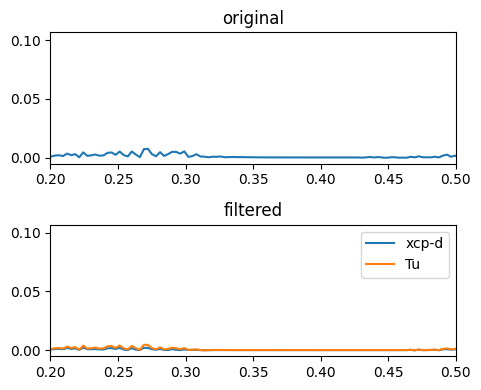

In [19]:
fs = 1 / TR  # Sampling frequency: 1 frame per 0.8 seconds => 1.25 Hz
N = unfiltered_mov_regressors.shape[0]  # Number of data points
xf = np.linspace(0.0, fs / 2.0, N // 2)

xcpd_filtered_signal = filter_motion(
    unfiltered_mov_regressors[:,:6],
    TR,
    motion_filter_type,
    band_stop_min,
    band_stop_max,
    motion_filter_order)
Tu_filtered_signal = filter_motion_butter(
    unfiltered_mov_regressors[:,:6],
    TR,
    motion_filter_type,
    band_stop_min,
    band_stop_max,
    motion_filter_order)

# Compute power spectrum
icol = 1
power_spectrum = calc_power_spectrum(unfiltered_mov_regressors[:,icol])
power_spectrum_filtered_xcpd = calc_power_spectrum(xcpd_filtered_signal[:,icol])
power_spectrum_filtered_Tu = calc_power_spectrum(Tu_filtered_signal[:,icol])


plt.figure(figsize=(5, 4))  
plt.subplot(2,1,1)
plt.plot(xf,power_spectrum)
plt.title('original')
ylims =plt.gca().get_ylim()
plt.xlim([0.2,0.5])
plt.subplot(2,1,2)
plt.plot(xf,power_spectrum_filtered_xcpd,label='xcp-d')
plt.plot(xf,power_spectrum_filtered_Tu,label='Tu')
plt.title('filtered')
plt.ylim(ylims)
plt.xlim([0.2,0.5])
plt.legend()
plt.tight_layout()
plt.show()


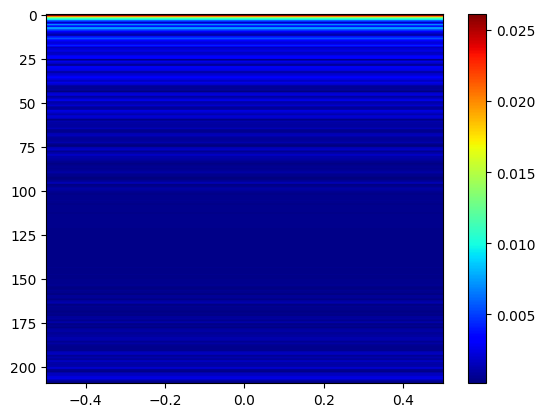

In [17]:

plt.imshow(np.expand_dims(power_spectrum,axis = 1),aspect='auto',cmap='jet')
plt.colorbar()
plt.show()

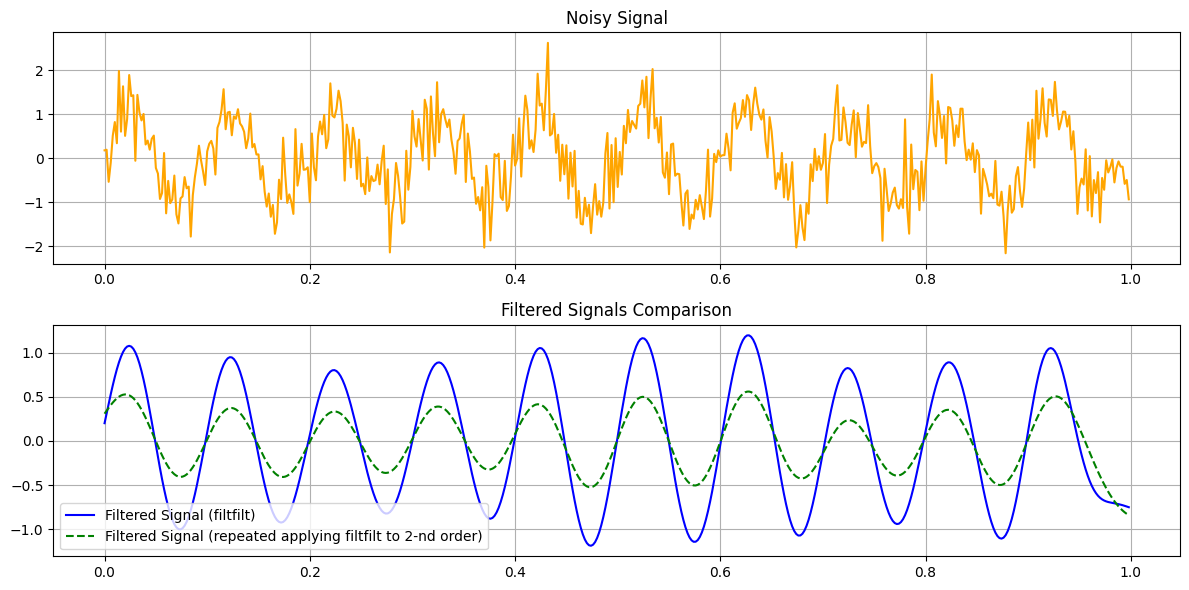

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, sosfiltfilt

# Sample data
fs = 500  # Sampling frequency
t = np.linspace(0, 1, fs, endpoint=False)  # Time vector
signal = np.sin(2 * np.pi * 10 * t) + 0.5 * np.random.normal(size=t.shape)  # Noisy signal

# Design a low-pass Butterworth filter
order = 10
cutoff = 15  # Cutoff frequency
sos = butter(order/2, cutoff, fs=fs,output='sos')  
filtered_signal_filtfilt = sosfiltfilt(sos, signal)

sos = butter(2, cutoff, fs=fs,output='sos')  
filtered_signal_repfiltfilt = signal.copy()
n_filter_applications = int(np.floor(order / 2))
for i in range(n_filter_applications):
        filtered_signal_repfiltfilt = sosfiltfilt(sos,filtered_signal_repfiltfilt)

# Plot results
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(t, signal, label='Noisy Signal', color='orange')
plt.title('Noisy Signal')
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(t, filtered_signal_filtfilt, label='Filtered Signal (filtfilt)', color='blue')
plt.plot(t, filtered_signal_repfiltfilt, label='Filtered Signal (repeated applying filtfilt to 2-nd order)', color='green', linestyle='--')
plt.title('Filtered Signals Comparison')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

### Compare the DCAN-MATLAB filtered movement parameters and Tu-Python filtered movement parameters ###

In [ ]:
#file_mov_reg = '/data/wheelock/data1/datasets/BCP/Example_BCP_intermediates/sub-100619/output_Tu/MNINonLinear/Results/ses-17mo_task-rest_run-001/DCANBOLDProc_vTu1.0/DCANBOLDProc_vTu1.0_bs16.8896_28.6662_filtered_Movement_Regressors.txt'
file_mov_reg = '/data/wheelock/data1/datasets/BCP/Example_BCP_intermediates/sub-100619/output_Tu/MNINonLinear/Results/ses-17mo_task-rest_run-001/Movement_Regressors_filtered_matlabscript.txt'
dcan_filtered_signal = np.loadtxt(file_mov_reg)
plt.figure(figsize=(6,4))
plt.subplot(1,2,1)
plt.plot(dcan_filtered_signal[:,:3],lw=0.5)
plt.title('DCAN-MATLAB')
file_mov_reg = '/data/wheelock/data1/datasets/BCP/Example_BCP_intermediates/sub-100619/output_Tu/MNINonLinear/Results/ses-17mo_task-rest_run-001/Movement_Regressors.txt'
unfiltered_mov_regressors = np.loadtxt(file_mov_reg)
filtered_mov_regressors = filter_movement_regressors(unfiltered_mov_regressors, TR, motion_filter_order, motion_filter_type, band_stop_min, band_stop_max)
plt.subplot(1,2,2)
plt.plot(filtered_mov_regressors[:,:3],lw=0.5)
plt.title('Tu-Python')
# N.B. The columns 4-6 (and 9-12) are not directly comparable to DCAN because rotations are in degrees not arc length
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(5, 4)) 
plt.subplot(2,1,1)
plt.plot(unfiltered_mov_regressors[:,0],lw=0.5)
ylims =plt.gca().get_ylim()
plt.title('original')
plt.subplot(2,1,2)
plt.plot(dcan_filtered_signal[:,0],lw=0.5,color='c',label='DCAN-MATLAB')
plt.plot(filtered_mov_regressors[:,0],lw=0.5,color='m',label='Tu-Python')
plt.ylim(ylims)
plt.title('filtered')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
fs = 1 / TR  # Sampling frequency: 1 frame per 0.8 seconds => 1.25 Hz
N = unfiltered_mov_regressors.shape[0]  # Number of data points
xf = np.linspace(0.0, fs / 2.0, N // 2)

# Compute power spectrum
power_spectrum = calc_power_spectrum(unfiltered_mov_regressors[:,0])
power_spectrum_filtered_DCAN = calc_power_spectrum(dcan_filtered_signal[:,0])
power_spectrum_filtered_Tu = calc_power_spectrum(filtered_mov_regressors[:,0])


plt.figure(figsize=(5, 4))  
plt.subplot(2,1,1)
plt.plot(xf,power_spectrum)
plt.title('original')
ylims =plt.gca().get_ylim()
plt.subplot(2,1,2)
plt.plot(xf,power_spectrum_filtered_DCAN,label='DCAN')
plt.plot(xf,power_spectrum_filtered_Tu,label='Tu')
plt.title('filtered')
plt.ylim(ylims)
plt.legend()
plt.tight_layout()
plt.show()

### Compare the DCAN-MATLAB FD and Tu-Python FD
DCAN-MATLAB FD had a bug where it assumed the columns 4-6 are in degrees but the filtered movement parameters they saved was already in arc length

In [ ]:
from scipy.io import loadmat
FD_DCAN = loadmat('/data/wheelock/data1/datasets/BCP/Example_BCP_intermediates/sub-100619/output_Tu/MNINonLinear/Results/ses-17mo_task-rest_run-001/DCANBOLDProc_vTu1.0/FD.mat')['FD'].squeeze()
path_mov_reg = '/data/wheelock/data1/datasets/BCP/Example_BCP_intermediates/sub-100619/output_Tu/MNINonLinear/Results/ses-17mo_task-rest_run-001/Movement_Regressors.txt'
unfiltered_mov_regressors = np.loadtxt(path_mov_reg)
filtered_mov_regressors = filter_movement_regressors(unfiltered_mov_regressors[:,:6], TR, motion_filter_order, motion_filter_type, band_stop_min, band_stop_max)
FD,meanFD = calc_FD(filtered_mov_regressors,1)
filtered_mov_regressors_arclength = filtered_mov_regressors.copy()
filtered_mov_regressors_arclength[:,3:] = filtered_mov_regressors[:,3:]*np.pi*brain_radius_mm/180
FD_arclength,meanFDarclength = calc_FD(filtered_mov_regressors_arclength,1)

In [ ]:
# Effect of calculating arc length twice (reduces FD but effect is small when the movement is small)
plt.plot(FD,label='Tu-Python(arc length calculated once)',linewidth=0.5)
plt.plot(FD_arclength,label='Tu-Python(arc length calculated twice)',linewidth=0.5)
plt.legend()
plt.title('FD')
plt.xlabel('TR')
plt.show()
print((meanFD,meanFDarclength))

plt.figure()
plt.plot(FD-FD_arclength)
plt.title('Difference')
plt.xlabel('TR')
plt.show()

In [ ]:
# Compare the saved DCAN output with the python output (note that there are differences in the filter too)
plt.plot(FD,label='Tu-Python(arc length calculated once)',linewidth=0.5)
plt.plot(FD_arclength,label='Tu-Python (arc length calculated twice)',linewidth=0.5)
plt.plot(FD_DCAN, label='DCAN-MATLAB',linewidth=0.5)
plt.legend()
plt.title('FD')
plt.xlabel('TR')
plt.show()
print((np.mean(FD_DCAN),meanFDarclength,meanFD))
print(np.sum(FD_DCAN < fd_th),np.sum(FD_arclength<fd_th),np.sum(FD < fd_th))

### Making Friston regressors from filtered V.S. unfiltered movement parameters

In [ ]:
FR_DCAN = loadmat('/data/wheelock/data1/datasets/BCP/Example_BCP_intermediates/sub-100619/output_Tu/MNINonLinear/Results/ses-17mo_task-rest_run-001/DCANBOLDProc_v4.0.0/FR.mat')['FR']
FR_filtered = make_friston_regressors(filtered_mov_regressors, hd_mm=50)
FR_unfiltered = make_friston_regressors(unfiltered_mov_regressors, hd_mm=50)
FR_arclength = make_friston_regressors(filtered_mov_regressors_arclength,hd_mm=50)


In [ ]:
plt.figure(figsize = (6,6))
plt.subplot(2,2,1)
plt.plot(FR_unfiltered,linewidth=0.5)
plt.ylim([-0.6,0.6])
plt.title('Unfiltered')
plt.xlabel('TR')
plt.subplot(2,2,2)
plt.plot(FR_filtered,linewidth=0.5)
plt.ylim([-0.6,0.6])
plt.title('Bandstop filtered')
plt.xlabel('TR')
plt.subplot(2,2,3)
plt.plot(FR_arclength,linewidth=0.5)
plt.ylim([-0.6,0.6])
plt.title('Repeated arc length')
plt.xlabel('TR')
plt.subplot(2,2,4)
plt.plot(FR_DCAN,linewidth=0.5)
plt.ylim([-0.6,0.6])
plt.title('DCAN-MATLAB output')
plt.xlabel('TR')
plt.tight_layout()
plt.show()

In [ ]:
# Unfiltered
R = np.concatenate((Glob,dGlob,FR_unfiltered),axis = 1) # with GSR
# Demean/detrend regressors
R = R-np.mean(R[keepframe,:],axis = 0)
R = detrend_manual(R,keepframe)
# Nuisance Regression
b,_,_,_ = np.linalg.lstsq(R[keepframe,:],data_dd[keepframe,:],rcond=None)
data_postreg = data_dd-R@b
DVAR_post_reg_unfiltered = calculate_dvars_from_cifti(data_postreg)

# Filtered
R = np.concatenate((Glob,dGlob,FR_filtered),axis = 1) # with GSR
# Demean/detrend regressors
R = R-np.mean(R[keepframe,:],axis = 0)
R = detrend_manual(R,keepframe)
# Nuisance Regression
b,_,_,_ = np.linalg.lstsq(R[keepframe,:],data_dd[keepframe,:],rcond=None)
data_postreg = data_dd-R@b
DVAR_post_reg_filtered = calculate_dvars_from_cifti(data_postreg)

# Repeated arc length
R = np.concatenate((Glob,dGlob,FR_arclength),axis = 1) # with GSR
# Demean/detrend regressors
R = R-np.mean(R[keepframe,:],axis = 0)
R = detrend_manual(R,keepframe)
# Nuisance Regression
b,_,_,_ = np.linalg.lstsq(R[keepframe,:],data_dd[keepframe,:],rcond=None)
data_postreg = data_dd-R@b
DVAR_post_reg_arclength = calculate_dvars_from_cifti(data_postreg)

# DCAN
R = np.concatenate((Glob,dGlob,FR_arclength),axis = 1) # with GSR
# Demean/detrend regressors
R = R-np.mean(R[keepframe,:],axis = 0)
R = detrend_manual(R,keepframe)
# Nuisance Regression
b,_,_,_ = np.linalg.lstsq(R[keepframe,:],data_dd[keepframe,:],rcond=None)
data_postreg = data_dd-R@b
DVAR_post_reg_DCAN = calculate_dvars_from_cifti(data_postreg)

In [ ]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(DVAR_pre_reg,linewidth=0.5)
plt.title('DVARS pre regression')
plt.xlabel('TR')
plt.subplot(1,2,2)
plt.plot(DVAR_post_reg_unfiltered,linewidth=0.5,label='Unfiltered',color='c')
plt.plot(DVAR_post_reg_filtered,linewidth=0.5,label='Bandstop filtered',color='m')
plt.plot(DVAR_post_reg_filtered,linewidth=0.5,label='Repeated arc length',color='r')
plt.plot(DVAR_post_reg_filtered,linewidth=0.5,label='DCAN-MATLAB output',color='b')
plt.title('DVARS post regression')
plt.xlabel('TR')
plt.tight_layout()
plt.legend()
plt.show()

plt.figure(figsize=(3,3))
plt.plot(DVAR_post_reg_unfiltered-DVAR_post_reg_filtered,linewidth=0.5)
plt.title('bandstop unfiltered - bandstop filtered')
plt.show()

plt.figure(figsize=(8,4))
plt.plot(DVAR_post_reg_unfiltered,linewidth=0.5,label='Unfiltered',color='c')
plt.plot(DVAR_post_reg_filtered,linewidth=0.5,label='Bandstop filtered',color='m')
plt.plot(DVAR_post_reg_filtered,linewidth=0.5,label='Repeated arc length',color='r')
plt.plot(DVAR_post_reg_filtered,linewidth=0.5,label='DCAN-MATLAB output',color='b')
plt.title('DVARS post regression')
plt.xlabel('TR')
plt.legend()
plt.show()

### Effect of making the extrapolated signals to mean instead of keeping the extrapolated values


In [ ]:
# Linear interpolation before bandpass filter (Line 144 in dcan_signal_processing.m)
# Interpolate for missing frames
x = np.where(keepframe)[0]
x_removed =  np.where(keepframe==0)[0]
x_outsidebound = (x_removed<x[0])|(x_removed>x[-1])
y_removed = np.apply_along_axis(
    lambda col: np.interp(x_removed, x, col[keepframe]), 
    axis=0, 
    arr=data_postreg
)
# Replace extrapolated points with the mean of kept data
y_mean = np.mean(data_postreg[keepframe,:],axis=0)
y_removed_withextrapolation = np.copy(y_removed)
y_removed[x_outsidebound,:] = y_mean 

data_interpolated = data_postreg.copy()
data_interpolated[keepframe==0,:] = y_removed
data_filtered = filter_bandpass(data_interpolated, TR, bp_order, lp_Hz , hp_Hz)
data_interpolated_withextrapolation  = data_postreg.copy()
data_interpolated_withextrapolation[keepframe==0,:] = y_removed_withextrapolation 
data_filtered_withextrapolation = filter_bandpass(data_interpolated_withextrapolation, TR, bp_order, lp_Hz , hp_Hz)

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(data_interpolated[:,0],linewidth=0.5,label='removing extrapolation with mean')
plt.plot(data_interpolated_withextrapolation[:,0],linewidth=0.5,label='with extrapolation')
plt.xlabel('TR')
plt.legend(loc='best')
plt.tight_layout()
plt.show()
plt.figure(figsize=(6,4))
plt.plot(data_filtered[:,0],linewidth=0.5,label='removing extrapolation with mean')
plt.plot(data_filtered_withextrapolation[:,0],linewidth=0.5,label='with extrapolation')
plt.xlabel('TR')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

### Compare different padding before bandpass filter

In [ ]:
# Bandpass filter
fs = 1 / TR
fNy = fs / 2 # Nyquist frequency
b_filt,a_filt = scipy.signal.butter(bp_order/2,np.array([lp_Hz,hp_Hz])/fNy,'bandpass')
# print(3*max(len(a_filt),len(b_filt))) # Default pad length
data_filtered = scipy.signal.filtfilt(b_filt,a_filt,data_interpolated,axis = 0,padtype='constant',padlen=data.shape[0]-1)
# data_filtered = scipy.signal.filtfilt(b_filt,a_filt,data_interpolated,axis = 0,padtype=None)
DVAR_post_filter = calculate_dvars_from_cifti(data_filtered)

In [ ]:
# Bandpass filter with manual zero padding
fs = 1 / TR
fNy = fs / 2 # Nyquist frequency
b_filt,a_filt = scipy.signal.butter(bp_order/2,np.array([lp_Hz,hp_Hz])/fNy,'bandpass')
# Zero-pad the data for filtering by concatenating rows of zeros on either side of the data
padding = np.zeros_like(data_interpolated)  # Create a padding array of the same shape as Rr_int
pad_amt = padding.shape[0]       # Number of rows to pad

# Concatenate padding rows on top and bottom of Rr_int
temp = np.vstack((padding, data_interpolated, padding))

# Apply the filtfilt function (zero-phase filtering)
data_filtered  = scipy.signal.filtfilt(b_filt, a_filt, temp, axis=0,padtype=None)  # Apply filtering along the rows (axis=0)
data_filtered = data_filtered[pad_amt:-pad_amt]

DVAR_post_filter = calculate_dvars_from_cifti(data_filtered)

In [ ]:
plt.plot(data_interpolated)
plt.show()

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(data_interpolated[:,0],linewidth=0.5,label='example pre-filtered signal')
plt.plot(data_filtered[:,0],linewidth=0.5,label='example post-filtered signal')
# for j in x_removed[x_outsidebound]:
#     plt.axvline(x=j, color="r", alpha=0.2)
plt.xlabel('TR')
plt.legend(loc='best')
plt.tight_layout()
plt.show()


In [ ]:
plt.figure(figsize=(4,2))
plt.subplot(1,2,1)
plt.plot(DVAR_post_filter,linewidth=0.5,label='DVARS post bandpass filter')
plt.xlabel('TR')
plt.title('DVARS')
plt.ylim([0,40])
plt.subplot(1,2,2)
n = data_filtered.shape[0]
frequencies = fs*np.arange(0,n//2+1)/n
plt.plot(frequencies[1:],calc_power_spectrum(data_filtered[:,0]),linewidth=0.5,label='Power spectrum for example signal')
plt.xlabel('Hz')
plt.title('Frequency spectrum')
plt.show()

### Change the order of regression and bandpass filtering

In [ ]:
# Linear interpolation before bandpass filter (Line 144 in dcan_signal_processing.m)
# Interpolate for missing frames
x = np.where(keepframe)[0]
x_removed =  np.where(keepframe==0)[0]
x_outsidebound = (x_removed<x[0])|(x_removed>x[-1])

y_removed = np.apply_along_axis(
    lambda col: np.interp(x_removed, x, col[keepframe]), 
    axis=0, 
    arr=data_dd
)
R_removed = np.apply_along_axis(
    lambda col: np.interp(x_removed, x, col[keepframe]), 
    axis=0, 
    arr=R
)

# Replace extrapolated points with the mean of kept data
y_mean = np.mean(data_dd[keepframe,:],axis=0)
y_removed[x_outsidebound,:] = y_mean 
R_mean = np.mean(R[keepframe,:],axis=0)
R_removed[x_outsidebound,:] = R_mean

data_interpolated = data_dd.copy()
data_interpolated[keepframe==0,:] = y_removed

R_interpolated = R.copy()
R_interpolated[keepframe==0,:] = R_removed


In [ ]:
# bandpass filter the cifti grayordinates
fs = 1 / TR
fNy = fs / 2 # Nyquist frequency
b_filt,a_filt = scipy.signal.butter(bp_order/2,np.array([lp_Hz,hp_Hz])/fNy,'bandpass')

# Zero-pad the data for filtering by concatenating rows of zeros on either side of the data
padding = np.zeros_like(data)  # Create a padding array of the same shape as Rr_int
pad_amt = padding.shape[0]       # Number of rows to pad

# Concatenate padding rows on top and bottom of Rr_int
temp = np.vstack((padding, data_interpolated, padding))

# Apply the filtfilt function (zero-phase filtering)
data_filtered  = scipy.signal.filtfilt(b_filt, a_filt, temp, axis=0,padtype=None)  # Apply filtering along the rows (axis=0)
data_filtered = data_filtered[pad_amt:-pad_amt]

DVAR_post_filter = calculate_dvars_from_cifti(data_filtered)

# Zero-pad the data for filtering by concatenating rows of zeros on either side of the data
padding = np.zeros_like(R)  # Create a padding array of the same shape as Rr_int
pad_amt = padding.shape[0]       # Number of rows to pad

# Concatenate padding rows on top and bottom of Rr_int
temp = np.vstack((padding, R_interpolated, padding))

# Apply the filtfilt function (zero-phase filtering)
R_filtered  = scipy.signal.filtfilt(b_filt, a_filt, temp, axis=0,padtype=None)  # Apply filtering along the rows (axis=0)
R_filtered = R_filtered[pad_amt:-pad_amt]

In [ ]:
plt.figure(figsize=(4,2))
plt.subplot(1,2,1)
plt.plot(DVAR_post_filter,linewidth=0.5,label='DVARS post bandpass filter')
plt.xlabel('TR')
plt.title('DVARS')
plt.subplot(1,2,2)
n = data.shape[0]
frequencies = fs*np.arange(0,n//2+1)/n
plt.plot(frequencies[1:],calc_power_spectrum(data_filtered[:,0]),linewidth=0.5,label='Power spectrum for example signal')
plt.xlabel('Hz')
plt.title('Frequency spectrum')
plt.show()

In [ ]:
# Now regression
b,_,_,_ = np.linalg.lstsq(R_filtered[keepframe,:],data_filtered[keepframe,:],rcond=None)
data_postreg = data_filtered-R_filtered@b
DVAR_post_reg = calculate_dvars_from_cifti(data_postreg)

In [ ]:
# Make cifti header to save filtered data
# img = nib.load(path_cii)  # This line was run at the beginning 
ax1 = img.header.get_axis(0)
ax2 = img.header.get_axis(1)
header = (ax1, ax2)
# Make and save image
output_img = nib.cifti2.cifti2.Cifti2Image(np.single(data_postreg), header)
output_img.to_filename(os.path.join(result_dir,FNL_preproc_CIFTI_basename + '_bandpassfirst.dtseries.nii'))

In [ ]:
plt.figure(figsize=(4,2))
plt.subplot(1,2,1)
plt.plot(DVAR_post_reg,linewidth=0.5,label='DVARS post bandpass filter')
plt.xlabel('TR')
plt.title('DVARS')
plt.ylim([0,40])
plt.subplot(1,2,2)
n = data.shape[0]
frequencies = fs*np.arange(0,n//2+1)/n
plt.plot(frequencies[1:],calc_power_spectrum(data_postreg[:,0]),linewidth=0.5,label='Power spectrum for example signal')
plt.xlabel('Hz')
plt.title('Frequency spectrum')
plt.ylim([-0.5,15.5])
plt.show()

In [ ]:
plt.figure(figsize=(4,4))
plt.plot(DVAR_pre_reg,linewidth=0.5,label='DVARS pre regression',color='b')
plt.plot(DVAR_post_filter,linewidth=0.5,label='DVARS post filtered',color='g')
plt.plot(DVAR_post_reg,linewidth=0.5,label='DVARS post regression',color='r')
plt.xlabel('TR')
plt.legend()
plt.show()

In [ ]:
plt.figure()
im = plt.imshow(data_filtered.transpose(), aspect="auto", cmap="gray")
plt.yticks([])
plt.show()
plt.figure()
im = plt.imshow(data_postreg.transpose(), aspect="auto", cmap="gray")
plt.yticks([])
plt.show()

In [ ]:
plt.figure()
plt.plot(data_dd[:,0])
plt.plot(data_filtered[:,0])
plt.plot(data_postreg[:,0])